In [1]:
import pandas as pd
from tqdm import tqdm
from catboost import CatBoostClassifier
pd.set_option('display.max_columns', None)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier

## Data

#### prediction

In [2]:
target_prediction = pd.read_csv('./data/target_predicton.csv')
target_prediction_true = pd.read_csv('./data/target_predicton_true.csv')

In [3]:
# Результат прогнозирования бейзлайна (прогноз по срезу парка на 1 декабря 2022)
print(target_prediction.shape)
target_prediction.head()

(33977, 3)


,wagnum,target_month,target_day
0,33361,0,0
1,33364,1,1
2,33366,1,1
3,33358,0,0
4,33349,0,0


In [4]:
# Эталонные метки (для аналогичного периода)
print(target_prediction_true.shape)
target_prediction_true.head()

(33977, 3)


,wagnum,target_month,target_day
0,33361,0,0
1,33364,1,1
2,33366,1,1
3,33358,0,0
4,33349,0,0


In [5]:
from data.metrics_f1 import calc_f1_score
calc_f1_score(
    test_url='/home/rustem/projs/pgk/data/target_predicton_true.csv',
    prediction_url='/home/rustem/projs/pgk/data/target_predicton.csv'
)

0.23121339736861674

#### target

In [15]:
y_predict = pd.read_csv('./data/y_predict.csv')
y_predict_submit_example = pd.read_csv('./data/y_predict_submit_example.csv')

y_train = pd.read_csv('./data/y_train.csv')
y_train['month'] = y_train['month'].astype('datetime64[ns]')

In [4]:
# Номера вагонов и даты, по которым необходимо сделать предсказание.
# Приджойните к этому файлу ваши ответы и загрузите на платформу.
print(y_predict.shape)
y_predict.head()

(33707, 2)


,wagnum,month
0,33361,2023-03-01
1,33364,2023-03-01
2,33366,2023-03-01
3,33358,2023-03-01
4,33349,2023-03-01


In [5]:
# Пример файла, который вы загрузите на платформу в качестве ответов.
print(y_predict_submit_example.shape)
y_predict_submit_example.head()

(33707, 4)


,wagnum,month,target_month,target_day
0,33361,2023-03-01,1,1
1,33364,2023-03-01,1,1
2,33366,2023-03-01,1,1
3,33358,2023-03-01,1,1
4,33349,2023-03-01,1,1


In [6]:
# Данные для обучения.
print(y_train.shape)
y_train.head()

(203853, 4)


,wagnum,month,target_month,target_day
0,33361,2023-01-01,0,0
1,33364,2023-01-01,0,0
2,33366,2023-01-01,0,0
3,33358,2023-01-01,0,0
4,33349,2023-01-01,0,0


In [7]:
y_train['month'].value_counts()

month
2022-12-01    33977
2022-09-01    33976
2022-10-01    33976
2022-11-01    33976
2022-08-01    33975
2023-01-01    33973
Name: count, dtype: int64

In [11]:
# данные по 2023-01-31

#### parquet

In [12]:
dislok_wagons = pd.read_parquet('./data/dislok_wagons.parquet', engine='pyarrow')
dislok_wagons = dislok_wagons.sort_values(by=['wagnum', 'plan_date'])

freight_info = pd.read_parquet('./data/freight_info.parquet', engine='pyarrow')

kti_izm = pd.read_parquet('./data/kti_izm.parquet', engine='pyarrow')
kti_izm['operation_date_dttm'] = kti_izm['operation_date_dttm'].astype('datetime64[ns]')

pr_rems = pd.read_parquet('./data/pr_rems.parquet', engine='pyarrow')
stations = pd.read_parquet('./data/stations.parquet', engine='pyarrow')
tr_rems = pd.read_parquet('./data/tr_rems.parquet', engine='pyarrow')
wag_params = pd.read_parquet('./data/wag_params.parquet', engine='pyarrow')
wagons_probeg_ownersip = pd.read_parquet('./data/wagons_probeg_ownersip.parquet', engine='pyarrow')

In [4]:
# Информация по дислокации
print(dislok_wagons.shape)
dislok_wagons.head()

(6250933, 16)


,plan_date,wagnum,date_kap,date_dep,kod_vrab,date_pl_rem,id_road_disl,st_id_dest,id_road_dest,st_id_send,id_road_send,ost_prob,isload,fr_id,last_fr_id,distance
17887,2022-08-01,0,2013-08-05,2020-05-06,0,2023-05-06,44,12202,44,11412,42,82413,1,1671,1671,-1.0
17888,2022-08-02,0,2013-08-05,2020-05-06,0,2023-05-06,44,12202,44,11412,42,81744,1,1671,1671,-1.0
17889,2022-08-03,0,2013-08-05,2020-05-06,0,2023-05-06,44,12202,44,11412,42,81744,1,1671,1671,-1.0
17890,2022-08-04,0,2013-08-05,2020-05-06,0,2023-05-06,44,12202,44,11412,42,81462,1,1671,1671,-1.0
17891,2022-08-05,0,2013-08-05,2020-05-06,0,2023-05-06,44,12202,44,11412,42,81462,1,1671,1671,-1.0


In [14]:
# Список вагонов по которым известен пробег и тип владения на дату среза
print(wagons_probeg_ownersip.shape)
wagons_probeg_ownersip.head()

(6249857, 8)


,repdate,wagnum,ost_prob,manage_type,rod_id,reestr_state,ownership_type,month
0,2022-08-01,33361,7541,0,1,1,0,8
1,2022-08-02,33361,7243,0,1,1,0,8
2,2022-08-03,33361,6990,0,1,1,0,8
3,2022-08-04,33361,6347,0,1,1,0,8
4,2022-08-05,33361,6027,0,1,1,0,8


In [15]:
# Справочник грузов
# (dislok_wagons -> fr_id)
print(freight_info.shape)
freight_info.head()

(5079, 9)


,fr_id,fr_class,skoroport,naval,nasip,naliv,openvagons,soprovod,smerz
0,4989,2,0,0,0,0,0,0,0
1,4990,2,0,0,0,0,0,0,0
2,4991,0,0,0,0,0,0,0,0
3,4992,2,0,0,0,0,0,0,0
4,4993,2,0,0,0,0,0,0,0


In [16]:
# Данные по КТИ
# (dislok_wagons -> wagnum)
print(kti_izm.shape)
kti_izm.head()

(22428, 19)


,wagnum,operation_date_dttm,mileage_all,axl1_l_w_flange,axl1_r_w_flange,axl2_l_w_flange,axl2_r_w_flange,axl3_l_w_flange,axl3_r_w_flange,axl4_l_w_flange,axl4_r_w_flange,axl1_l_w_rim,axl1_r_w_rim,axl2_l_w_rim,axl2_r_w_rim,axl3_l_w_rim,axl3_r_w_rim,axl4_l_w_rim,axl4_r_w_rim
43,1302,2023-02-17,67638.0,29.6,29.5,30.0,29.6,30.2,29.9,30.9,29.5,37.8,39.2,39.5,38.9,41.8,38.9,36.5,38.2
60,1374,2023-02-25,83798.0,29.1,27.9,27.7,29.1,29.3,30.2,29.4,27.5,48.9,49.0,49.7,51.0,30.7,32.4,30.6,28.8
137,2916,2023-02-21,121660.0,30.4,26.5,30.8,28.2,26.9,27.1,29.8,31.2,69.2,66.7,66.8,63.7,66.1,66.3,68.1,67.6
196,3849,2023-02-19,59664.0,30.6,29.2,31.6,28.5,31.0,30.7,29.3,30.0,75.1,76.1,74.8,73.7,75.6,76.8,72.2,72.9
197,3849,2023-02-20,59664.0,30.9,28.7,32.4,28.1,31.0,29.7,30.5,29.9,75.6,76.8,74.1,74.7,75.8,77.0,74.9,74.2


In [17]:
# Данные по плановым ремонтам
print(pr_rems.shape)
pr_rems.head()

(10441, 11)


,wagnum,rem_month,rod_id,model,road_id_send,road_id_rem,kod_vrab,st_id_send,st_id_rem,distance,month
0,15000,2022-08-05,1,12-132,3,3,0,493,493,37.0,8
2,25485,2022-08-21,1,12-132-03,13,13,0,6152,4793,360.0,8
3,25944,2022-08-09,1,12-132-03,13,13,1,6152,4793,322.0,8
4,24080,2022-08-13,1,12-296-01,13,13,0,6152,4793,308.0,8
5,28612,2022-08-09,1,12-132,13,13,0,6152,4793,373.0,8


In [18]:
# Справочник станций
print(stations.shape)
stations.head()

(148032, 9)


,st_id,road_id,st_border_sign,st_sea_sign,st_river_sign,st_car_sign,st_ferry_sign,st_freigh_sign,opor_station_sign
0,13069,47,0,0,0,0,0,0,0
1,9353,18,0,0,0,0,0,0,0
2,9973,19,0,0,0,0,0,1,0
3,13745,6,0,0,0,0,0,0,0
4,14554,15,0,0,0,0,0,0,0


In [19]:
# Данные по текущим ремонтам
print(tr_rems.shape)
tr_rems.head()

(48652, 17)


,wagnum,rem_month,kod_vrab,neis1_kod,neis2_kod,neis3_kod,mod1_kod,mod2_kod,mod3_kod,mod4_kod,mod5_kod,mod6_kod,mod7_kod,road_id_send,gr_probeg,por_probeg,st_id_send
0,29938,2022-08-01,3,0,98,54,7,4,2,0,0,0,0,38,87913,37467,10522
1,29938,2022-08-01,3,14,98,54,7,4,2,0,0,0,0,38,87913,37467,10441
2,29852,2022-08-01,2,0,98,54,7,4,2,0,0,0,0,28,81824,45579,4789
3,29852,2022-08-01,2,36,98,54,7,4,2,0,0,0,0,28,81824,45579,4789
4,13674,2022-08-01,2,95,98,54,7,4,2,0,0,0,0,28,64130,34697,4789


In [20]:
# Данные по характеристикам вагона
print(wag_params.shape)
wag_params.head()

(33977, 20)


,wagnum,model,rod_id,gruz,cnsi_gruz_capacity,cnsi_volumek,tara,date_build,srok_sl,zavod_build,date_iskl,cnsi_probeg_dr,cnsi_probeg_kr,kuzov,telega,tormoz,tipvozd,tippogl,norma_km,ownertype
3218,26318,12-600-04,1,682,682,85.0,240,1992-12-25,2022-04-27,5,2023-02-16,160,160,2,9,3,6,11,110000,0
19128,28344,12-132,1,700,700,88.0,240,2003-08-12,2024-12-24,0,2022-12-14,110,160,2,9,2,1,12,0,0
21526,8099,11-286,0,670,670,138.0,270,1995-08-31,2027-10-01,1,NaT,110,160,2,9,2,1,1,160000,1
32353,33350,12-9850-02,1,750,750,90.0,248,2014-10-27,2047-02-05,19,NaT,250,500,2,11,2,7,12,250000,1
81,5308,11-276,0,680,680,122.0,260,1995-09-17,2027-09-28,1,NaT,110,160,2,9,2,1,11,160000,1


In [10]:
wag_params.dtypes

wagnum                         int64
model                 string[python]
rod_id                         int64
gruz                           Int64
cnsi_gruz_capacity             Int64
cnsi_volumek                 Float64
tara                           Int64
date_build            datetime64[ns]
srok_sl               datetime64[ns]
zavod_build                    int64
date_iskl             datetime64[ns]
cnsi_probeg_dr                 Int64
cnsi_probeg_kr                 Int64
kuzov                          Int64
telega                         Int64
tormoz                         Int64
tipvozd               string[python]
tippogl                        Int64
norma_km                       Int64
ownertype                      int64
dtype: object

In [11]:
wag_params['tipvozd'].astype(float)

3218     6.0
19128    1.0
21526    1.0
32353    7.0
81       1.0
        ... 
33703    7.0
33704    7.0
33705    7.0
33706    7.0
33707    7.0
Name: tipvozd, Length: 33977, dtype: float64

## CatBoost и kNN

In [2]:
y_predict = pd.read_csv('./data/y_predict.csv')

In [3]:
y_train1 = pd.read_csv('./data/y_train.csv')
y_train1['month'] = y_train1['month'].astype('datetime64[ns]')
y_train2 = pd.read_csv('./data/feb/y_test.csv')
y_train2['month'] = y_train2['month'].astype('datetime64[ns]')
y_train = pd.concat([y_train1, y_train2])

dislok_wagons1 = pd.read_parquet(
    './data/dislok_wagons.parquet', engine='pyarrow')
dislok_wagons2 = pd.read_parquet(
    './data/feb/dislok_wagons.parquet', engine='pyarrow')
dislok_wagons = pd.concat([dislok_wagons1, dislok_wagons2])
del dislok_wagons1, dislok_wagons2
dislok_wagons = dislok_wagons.sort_values(by=['wagnum', 'plan_date'])
dislok_wagons['ost_prob'] = dislok_wagons['ost_prob'].astype(float)
dislok_wagons = dislok_wagons[
    dislok_wagons['plan_date'] >= pd.to_datetime('2022-10-01')]

freight_info = pd.read_parquet('./data/freight_info.parquet', engine='pyarrow')

wag_params = pd.read_parquet('./data/wag_params.parquet', engine='pyarrow')
wag_params['tipvozd'] = wag_params['tipvozd'].astype(float)
wag_params = wag_params.drop(['model', 'date_iskl'], axis=1)

dislok_wagons = dislok_wagons.merge(
    right=freight_info,
    left_on='fr_id',
    right_on='fr_id',
    how='left'
    ).merge(
        right=freight_info,
        left_on='last_fr_id',
        right_on='fr_id',
        how='left',
        suffixes=(None, '_last_fr_id')
    ).merge(
        right=wag_params,
        left_on='wagnum',
        right_on='wagnum',
        how='left'
    )

# Оставляем вагоны, временные ряды по которым начинаются с 2022-10-01
# и заканчиваются 2023-03-01 с длительностю 152 наблюдения
target_wagons = dislok_wagons.groupby('wagnum').apply(
    lambda df_:
        (df_.iloc[0]['plan_date'] == pd.to_datetime('2022-10-01'))
        & (df_.iloc[-1]['plan_date'] == pd.to_datetime('2023-03-01'))
        & (df_.shape[0] == 152)
    )
target_wagons = target_wagons[target_wagons]

# Оставляем наблюдения по соответствующим вагонам
dislok_wagons = dislok_wagons[
    dislok_wagons['wagnum'].isin(target_wagons.index.tolist())]

# Джойним таргет и обучаем CatBoost
dislok_wagons['date_to_merge'] = dislok_wagons['plan_date'].map(
    lambda x:
        '2023-03-01' if x.month == 2
        else '2023-02-01' if x.month == 1
        else '2023-01-01' if x.month == 12
        else '2022-12-01' if x.month == 11
        else '2022-11-01' if x.month == 10
        else '2022-10-01' if x.month == 9
        else '2022-09-01' if x.month == 8
        else '1970-01-01'
)
dislok_wagons['date_to_merge'] = dislok_wagons['date_to_merge']\
    .astype('datetime64[ns]')
dislok_wagons['date_kap'] = dislok_wagons['date_kap'].astype('datetime64[ns]')
dislok_wagons['date_dep'] = dislok_wagons['date_dep'].astype('datetime64[ns]')
dislok_wagons['days_to_predict'] = (
    dislok_wagons['date_to_merge'] - dislok_wagons['plan_date']).dt.days
dislok_wagons = dislok_wagons.merge(
    right=y_train,
    left_on=['wagnum', 'date_to_merge'],
    right_on=['wagnum', 'month'],
    how='left')

dislok_wagons = dislok_wagons.assign(
    plane_date_day=dislok_wagons['plan_date'].dt.day,
    plane_date_month=dislok_wagons['plan_date'].dt.month,
    plane_date_year=dislok_wagons['plan_date'].dt.year,
    plane_date_dayofweek=dislok_wagons['plan_date'].dt.day_of_week,

    date_kap_day=dislok_wagons['date_kap'].dt.day,
    date_kap_month=dislok_wagons['date_kap'].dt.month,
    date_kap_year=dislok_wagons['date_kap'].dt.year,
    date_kap_dayofweek=dislok_wagons['date_kap'].dt.day_of_week,

    date_dep_day=dislok_wagons['date_dep'].dt.day,
    date_dep_month=dislok_wagons['date_dep'].dt.month,
    date_dep_year=dislok_wagons['date_dep'].dt.year,
    date_dep_dayofweek=dislok_wagons['date_dep'].dt.day_of_week,

    date_pl_rem_day=dislok_wagons['date_pl_rem'].dt.day,
    date_pl_rem_month=dislok_wagons['date_pl_rem'].dt.month,
    date_pl_rem_year=dislok_wagons['date_pl_rem'].dt.year,
    date_pl_rem_dayofweek=dislok_wagons['date_pl_rem'].dt.day_of_week,

    date_build_day=dislok_wagons['date_build'].dt.day,
    date_build_month=dislok_wagons['date_build'].dt.month,
    date_build_year=dislok_wagons['date_build'].dt.year,
    date_build_dayofweek=dislok_wagons['date_build'].dt.day_of_week,

    srok_sl_day=dislok_wagons['srok_sl'].dt.day,
    srok_sl_month=dislok_wagons['srok_sl'].dt.month,
    srok_sl_year=dislok_wagons['srok_sl'].dt.year,
    srok_sl_dayofweek=dislok_wagons['srok_sl'].dt.day_of_week
)

train = dislok_wagons[
    dislok_wagons['plan_date'] <= pd.to_datetime('2022-12-31')]
val = dislok_wagons[
    (dislok_wagons['plan_date'] >= pd.to_datetime('2023-01-01'))
    & (dislok_wagons['plan_date'] <= pd.to_datetime('2023-01-31'))]
x_to_forecast_mar = dislok_wagons[
    (dislok_wagons['plan_date'] >= pd.to_datetime('2023-02-01'))
    & (dislok_wagons['plan_date'] <= pd.to_datetime('2023-02-28'))]
del dislok_wagons

train['ost_prob'] = train['ost_prob'].fillna(train['ost_prob'].median())
val['ost_prob'] = val['ost_prob'].fillna(val['ost_prob'].median())
x_to_forecast_mar['ost_prob'] = x_to_forecast_mar['ost_prob']\
    .fillna(x_to_forecast_mar['ost_prob'].median())

train = train.select_dtypes(exclude='datetime64[ns]')
val = val.select_dtypes(exclude='datetime64[ns]')
x_to_forecast_mar = x_to_forecast_mar.select_dtypes(exclude='datetime64[ns]')

val = val.fillna(0)
train = train.fillna(0)
x_to_forecast_mar = x_to_forecast_mar.fillna(0)

x_to_forecast_mar = x_to_forecast_mar\
    .drop(['target_month', 'target_day'], axis=1)
x_train = train.drop(['target_month', 'target_day'], axis=1)
x_val = val.drop(['target_month', 'target_day'], axis=1)

y_train_month = train['target_month']
y_train_day = train['target_day']

y_val_month = val['target_month']
y_val_day = val['target_day']

In [4]:
cat_day = CatBoostClassifier()
cat_day.load_model(
    fname='/home/rustem/projs/pgk/models/cat_day.cbm'
)
cat_month = CatBoostClassifier()
cat_month.load_model(
    fname='/home/rustem/projs/pgk/models/cat_month.cbm'
)

<Axes: >

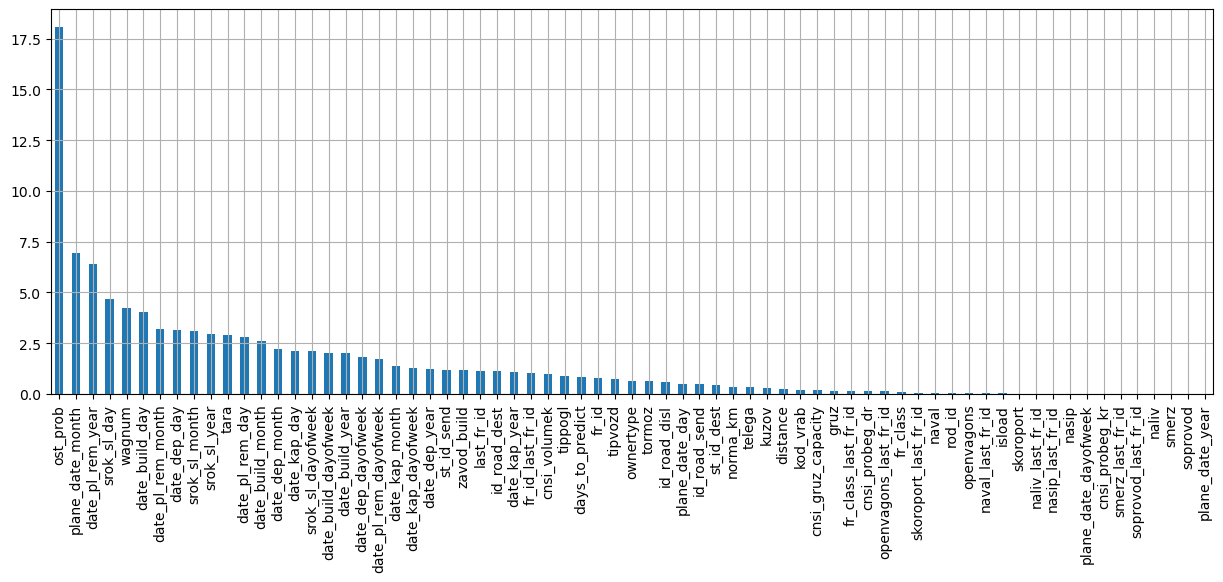

In [5]:
pd.Series(
    index=x_train.columns,
    data=cat_day.get_feature_importance()
).sort_values(ascending=False).plot(kind='bar', grid=True, figsize=(15, 5))

<Axes: >

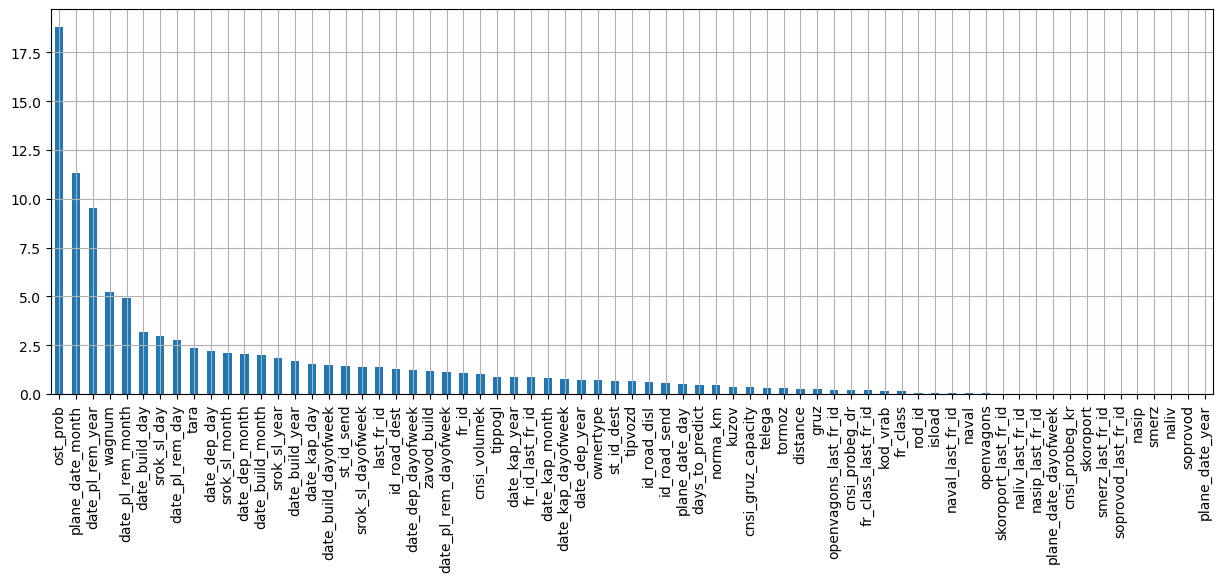

In [6]:
pd.Series(
    index=x_train.columns,
    data=cat_month.get_feature_importance()
).sort_values(ascending=False).plot(kind='bar', grid=True, figsize=(15, 5))

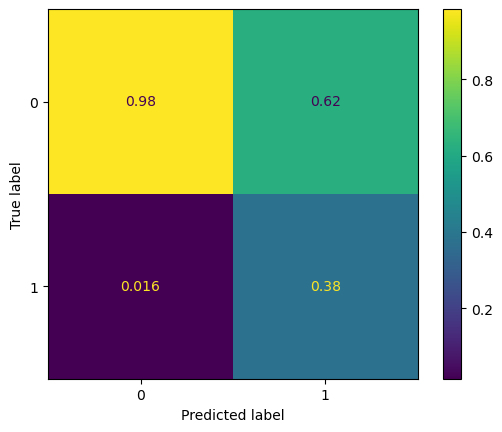

In [8]:
y_hat = cat_day.predict(x_val)
ConfusionMatrixDisplay(confusion_matrix(y_true=y_val_day, y_pred=y_hat, normalize='pred')).plot()

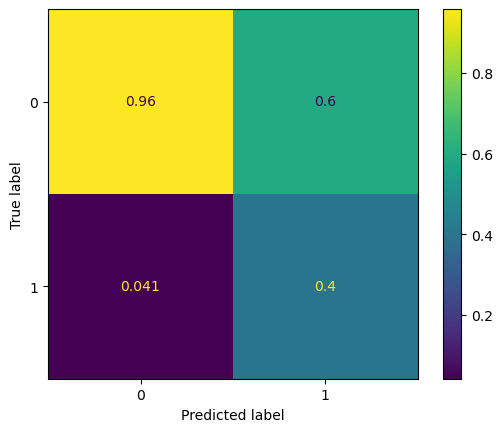

In [9]:
y_hat = cat_month.predict(x_val)
ConfusionMatrixDisplay(confusion_matrix(y_true=y_val_month, y_pred=y_hat, normalize='pred')).plot()

In [10]:
df = pd.concat([train, val])\
    .sort_values(['wagnum', 'plane_date_year', 'plane_date_month', 'plane_date_day'])

df_probas = pd.DataFrame({
    'wagnum': df['wagnum'],
    'plane_date_year': df['plane_date_year'],
    'plane_date_month': df['plane_date_month'],
    'probas_month': cat_month.predict_proba(df.drop(['target_day', 'target_month'], axis=1))[:, 1],
    'target_month': df['target_month'],
    'probas_day': cat_day.predict_proba(df.drop(['target_day', 'target_month'], axis=1))[:, 1],
    'target_day': df['target_day']
})
del df

embeds = df_probas.groupby(['wagnum', 'plane_date_year', 'plane_date_month']).agg({
    'probas_month': list, 'target_month': 'first',
    'probas_day': list, 'target_day': 'first'
})
del df_probas, train, val

In [11]:
for i in tqdm(range(0, embeds.shape[0]), total=embeds.shape[0]):
    if len(embeds.iloc[i]['probas_month']) == 30:
        embeds.iloc[i]['probas_month'].append(0)
    if len(embeds.iloc[i]['probas_day']) == 30:
        embeds.iloc[i]['probas_day'].append(0)
    if len(embeds.iloc[i]['probas_month']) == 28:
        embeds.iloc[i]['probas_month'].extend([0, 0, 0])
    if len(embeds.iloc[i]['probas_day']) == 28:
        embeds.iloc[i]['probas_day'].extend([0, 0, 0])

100%|██████████| 134728/134728 [00:21<00:00, 6353.43it/s]


In [10]:
# ПОТОМ УДАЛИТЬ
embeds = embeds.reset_index()
embeds = embeds.sort_values(['wagnum', 'plane_date_year', 'plane_date_month'])
embeds_val = embeds[embeds['plane_date_month'] == 11]
embeds_train = embeds.drop(embeds_val.index)

In [12]:
knn_month = KNeighborsClassifier(n_neighbors=5)
knn_month.fit(X=embeds['probas_month'].tolist(), y=embeds['target_month'].tolist())

knn_day = KNeighborsClassifier(n_neighbors=5)
knn_day.fit(X=embeds['probas_day'].tolist(), y=embeds['target_day'].tolist())

KNeighborsClassifier()

In [12]:
predicts = pd.DataFrame({
    'wagnum': embeds_val['wagnum'],
    'target_month': knn_month.predict(embeds_val['probas_month'].tolist()),
    'target_day': knn_day.predict(embeds_val['probas_day'].tolist())
})

In [13]:
predicts.to_csv('./data/predicts.csv', index=0)
embeds_val[['wagnum', 'target_month', 'target_day']].to_csv('./data/val.csv', index=0)

In [14]:
from data.metrics_f1 import calc_f1_score
calc_f1_score(test_url='./data/val.csv', prediction_url='./data/predicts.csv')

0.26229311659247967

In [13]:
df_probas_submit = pd.DataFrame({
    'wagnum': x_to_forecast_mar['wagnum'],
    'plane_date_year': x_to_forecast_mar['plane_date_year'],
    'plane_date_month': x_to_forecast_mar['plane_date_month'],
    'probas_month': cat_month.predict_proba(x_to_forecast_mar)[:, 1],
    'probas_day': cat_day.predict_proba(x_to_forecast_mar)[:, 1]
})

In [14]:
embeds_submit = df_probas_submit.groupby(['wagnum', 'plane_date_year', 'plane_date_month']).agg({
    'probas_month': list,
    'probas_day': list
}).reset_index()

In [15]:
for i in tqdm(range(0, embeds_submit.shape[0]), total=embeds_submit.shape[0]):
    if len(embeds_submit.iloc[i]['probas_month']) == 30:
        embeds_submit.iloc[i]['probas_month'].append(0)
    if len(embeds_submit.iloc[i]['probas_day']) == 30:
        embeds_submit.iloc[i]['probas_day'].append(0)
    if len(embeds_submit.iloc[i]['probas_month']) == 28:
        embeds_submit.iloc[i]['probas_month'].extend([0, 0, 0])
    if len(embeds_submit.iloc[i]['probas_day']) == 28:
        embeds_submit.iloc[i]['probas_day'].extend([0, 0, 0])

100%|██████████| 33682/33682 [00:05<00:00, 6069.50it/s]


In [16]:
predicts = pd.DataFrame({
    'wagnum': embeds_submit['wagnum'],
    'target_month': knn_month.predict(embeds_submit['probas_month'].tolist()),
    'target_day': knn_day.predict(embeds_submit['probas_day'].tolist())
})

In [17]:
predicts

,wagnum,target_month,target_day
0,0,0.0,0.0
1,1,0.0,0.0
2,2,0.0,0.0
3,3,0.0,0.0
4,4,0.0,0.0
...,...,...,...
33677,33972,0.0,0.0
33678,33973,0.0,0.0
33679,33974,0.0,0.0
33680,33975,0.0,0.0


In [18]:
predicts['target_month'].value_counts()

target_month
0.0    33264
1.0      418
Name: count, dtype: int64

In [19]:
predicts['target_day'].value_counts()

target_day
0.0    33656
1.0       26
Name: count, dtype: int64

In [20]:
submit = y_predict.merge(
    right=predicts,
    left_on='wagnum',
    right_on='wagnum',
    how='left').fillna(0)
submit.to_csv('/home/rustem/projs/pgk/data/submit.csv', index=0)